# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## Solutions


In this exercise, I extended the Genetic Algorithm (GA) developed in Exercise 9 to solve a larger instance of the Traveling Salesman Problem (TSP) using parallel computing with MPI (Message Passing Interface) libraries.

Specifically, I applied the parallel GA to the case of 110 Italian provincial capitals, whose geographical positions (latitude and longitude) are provided in the `cap_prov_ita.dat` file. The optimization goal is to find the shortest closed path that visits each city exactly once.

### Strategy

The parallel implementation follows a "Continents" Model, where:

- Each MPI process independently executes a separate GA search (called a *Continent*), evolving its own population.
- Every $N_{\text{migr}}$ generations, the Continents exchange their best individuals to share good solutions and potentially accelerate convergence.


The migration mechanism is implemented as follows:

1. **Best Individual Extraction**: Each process selects its current best individual.
2. **Encoding**: The individual's path is encoded into a vector of integers for communication.
3. **Exchange via Ring Topology**:
   - Each process sends its best individual to the next process in a logical ring.
   - Simultaneously, it receives the best individual from the previous process.
4. **Immigration**:
   - The received individual is decoded back into a proper path.
   - The worst individual in the current process’s population is replaced by this immigrant.
5. **Re-sorting**: After migration, the local population is re-sorted by fitness to maintain correct order.

This strategy ensures a cyclic exchange of best solutions across all processes.


### Simulation Setups

I performed three types of simulations to analyze the impact of migration:

| **Setup**    | **Description**                                                | **Processes** | **M** | **Generations** | **$N_{\text{migr}}$** |
|--------------|---------------------------------------------------------------|---------------|-------|-----------------|-----------------|
| **Migration**   | MPI-enabled GA with migration between Continents               | 4             | 1000  | 1000            | 15              |
| **No Migration** | MPI-enabled GA with *no* migration (isolated Continents)      | 4             | 1000  | 1000            | 1001            |
| **Independent** | Single-process GA, as in Exercise 9 (no communication)        | 1             | 4000  | 1000            | 1001            |



- **Migration**: 4 parallel MPI processes (continents), each with an independent GA, exchanging their best individuals every $N_{\text{migr}} = 15$ generations.
   
- **No Migration**: 4 parallel MPI processes running completely independent GA simulations, with $N_{\text{migr}} = 1001$ to effectively prevent migration.
   
- **Independent**: A single GA simulation (1 process) with a larger population size ($M = 4000$) to use computational resources comparable to the other two setups.


### Evaluation Metrics

- **Loss Function**: As in the previous exercise, I compute the total path length using the **Haversine distance** between geographic coordinates to accurately measure real distances on the Earth's surface: $L^{(1)} = \sum_{i=1}^N d_H(\vec{x}_i, \vec{x}_{i+1})$

- **Convergence Analysis**: For each simulation, I track:
  - The **best loss** (shortest path found at each generation).
  - The **average loss** computed over the best half of the population, to assess the spread and convergence of solutions.


- **Visualization**: 
  - I visualize the best final path found for each setup.
  - I compare the evolution of the loss function over generations across the three simulations to assess whether migration helps in reaching better solutions or faster convergence.

<!-- ## Objective

Finally, I compare the **quality of the final solutions** and the **convergence speed** of the three approaches to evaluate whether **parallelization with migration improves performance** compared to purely independent GA searches or single-process GA execution. -->


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

plt.rcParams.update({'font.size': 22})

def load_best_solution(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    distance = None
    order = []

    for line in lines:
        if "distance:" in line:
            # Estrae la distanza come float
            distance = float(line.strip().split("distance:")[1].split()[0])
        elif line.startswith("Province order:"):
            # Estrae gli ID delle province
            parts = line.strip().split(':')[1]
            order = [int(x) for x in parts.strip().split()]

    return order, distance


shapefile_path = 'Countries/ne_110m_admin_0_countries.shp'

world = gpd.read_file(shapefile_path)
italy = world[world['NAME'] == 'Italy']

provinces = np.loadtxt('MIGRATION/OUTPUT/provinces.dat', skiprows=1)
id_to_idx = {int(pid): idx for idx, pid in enumerate(provinces[:, 0])}
start_idx = id_to_idx[1]  

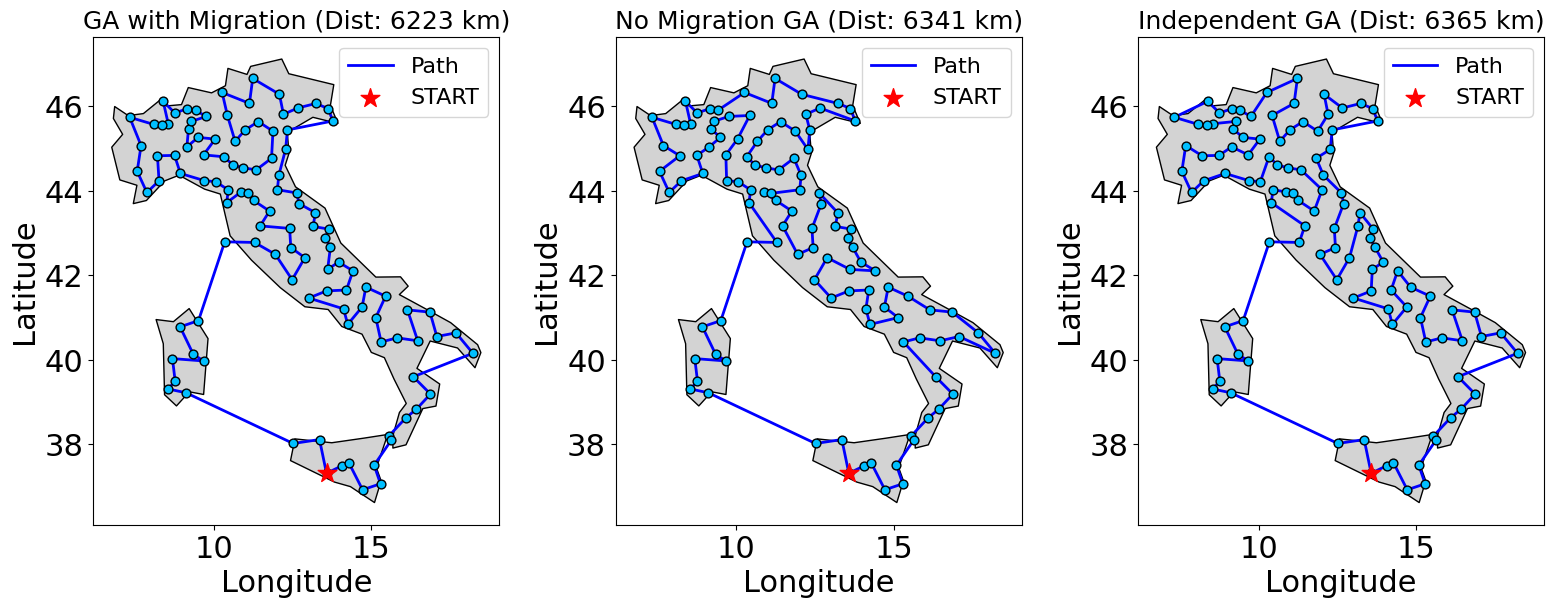

In [30]:
path1, dist1 = load_best_solution('MIGRATION/OUTPUT/global_best_solution.dat')
path2, dist2 = load_best_solution('NO_MIGRATION/OUTPUT/global_best_solution.dat')
path3, dist3 = load_best_solution('INDEPENDENT_GA/OUTPUT/global_best_solution.dat')

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes = axes.flatten()

paths = [path1, path2, path3]
titles = [f'GA with Migration (Dist: {dist1:.0f} km)', f'No Migration GA (Dist: {dist2:.0f} km)', f'Independent GA (Dist: {dist3:.0f} km)']

for i in range(len(paths)):
    ax = axes[i]
    italy.plot(ax=ax, color='lightgray', edgecolor='black')

    ax.scatter(provinces[:, 1], provinces[:, 2], color='deepskyblue', edgecolor='black', zorder=2, s=40)

    x = [provinces[id_to_idx[pid], 1] for pid in paths[i]] + [provinces[id_to_idx[paths[i][0]], 1]]
    y = [provinces[id_to_idx[pid], 2] for pid in paths[i]] + [provinces[id_to_idx[paths[i][0]], 2]]

    ax.plot(x, y, color='blue', linewidth=2, zorder=1, label='Path')

    start_idx = id_to_idx[paths[i][0]]
    ax.scatter(provinces[start_idx, 1], provinces[start_idx, 2], color='red', marker='*', s=200, zorder=3, label='START')

    ax.set_title(titles[i], fontsize=18)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()

C:\Users\Utente\AppData\Local\Temp\ipykernel_30620\477332963.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


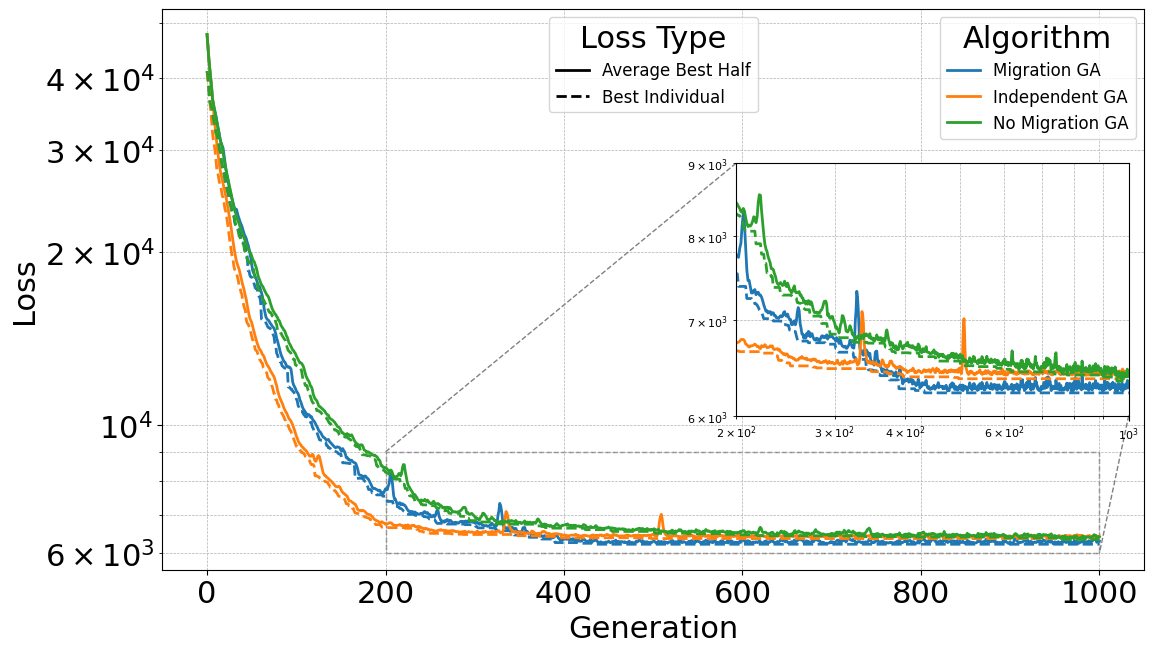

In [31]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# def load_avg_losses(path_prefix):
#     losses_best_half = []
#     losses_best = []
#     for i in range(4):
#         data = np.loadtxt(f'{path_prefix}/loss_rank{i}.dat', skiprows=1)
#         gen = data[:, 0]
#         losses_best_half.append(data[:, 2])  # best half
#         losses_best.append(data[:, 1])       # best individual
#     avg_best_half = np.mean(losses_best_half, axis=0)
#     avg_best = np.mean(losses_best, axis=0)
#     return gen, avg_best_half, avg_best

# gen_mig, mig_best_half, mig_best = load_avg_losses('MIGRATION/OUTPUT')
loss_indep = np.loadtxt('INDEPENDENT_GA/OUTPUT/loss_rank0.dat', skiprows=1)
loss_migration = np.loadtxt('MIGRATION/OUTPUT/loss_rank0.dat', skiprows=1)
loss_no_mig = np.loadtxt('NO_MIGRATION/OUTPUT/loss_rank0.dat', skiprows=1)
# gen_no_mig, no_mig_best_half, no_mig_best = load_avg_losses('NO_MIGRATION/OUTPUT')

fig, ax = plt.subplots(figsize=(12, 7))

# l1, = ax.plot(gen_mig, mig_best_half, color='tab:blue', linewidth=2)
# l2, = ax.plot(gen_mig, mig_best, color='tab:blue', linestyle='--', linewidth=2)
l1, = ax.plot(loss_migration[:, 0], loss_migration[:, 2], color='tab:blue', linewidth=2)
l2, = ax.plot(loss_migration[:, 0], loss_migration[:, 1], color='tab:blue', linestyle='--', linewidth=2)

l3, = ax.plot(loss_indep[:, 0], loss_indep[:, 2], color='tab:orange', linewidth=2)
l4, = ax.plot(loss_indep[:, 0], loss_indep[:, 1], color='tab:orange', linestyle='--', linewidth=2)

# l5, = ax.plot(gen_no_mig, no_mig_best_half, color='tab:green', linewidth=2)
# l6, = ax.plot(gen_no_mig, no_mig_best, color='tab:green', linestyle='--', linewidth=2)
l5, = ax.plot(loss_no_mig[:,0], loss_no_mig[:,2], color='tab:green', linewidth=2)
l6, = ax.plot(loss_no_mig[:,0], loss_no_mig[:,1], color='tab:green', linestyle='--', linewidth=2)

ax.set_xlabel('Generation')
ax.set_ylabel('Loss')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Legenda 1: colori (algoritmi)
legend1 = ax.legend(
    handles=[l1, l3, l5],
    labels=['Migration GA', 'Independent GA', 'No Migration GA'],
    loc='upper right',
    fontsize=12,
    title='Algorithm'
)

# Legenda 2: linee (tipo di loss)
custom_lines = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2)
]
legend2 = ax.legend(
    handles=custom_lines,
    labels=['Average Best Half', 'Best Individual'],
    loc='upper center',
    fontsize=12,
    title='Loss Type'
)

ax.add_artist(legend1)

axins = inset_axes(ax, width="40%", height="45%", loc='center right')

# Ridisegna le stesse curve nell'inset
# axins.plot(gen_mig, mig_best_half, color='tab:blue', linewidth=2)
# axins.plot(gen_mig, mig_best, color='tab:blue', linestyle='--', linewidth=2)
axins.plot(loss_migration[:, 0], loss_migration[:, 2], color='tab:blue', linewidth=2)
axins.plot(loss_migration[:, 0], loss_migration[:, 1], color='tab:blue', linestyle='--', linewidth=2)
axins.plot(loss_indep[:, 0], loss_indep[:, 2], color='tab:orange', linewidth=2)
axins.plot(loss_indep[:, 0], loss_indep[:, 1], color='tab:orange', linestyle='--', linewidth=2)

# axins.plot(gen_no_mig, no_mig_best_half, color='tab:green', linewidth=2)
# axins.plot(gen_no_mig, no_mig_best, color='tab:green', linestyle='--', linewidth=2)
axins.plot(loss_no_mig[:,0], loss_no_mig[:,2], color='tab:green', linewidth=2)
axins.plot(loss_no_mig[:,0], loss_no_mig[:,1], color='tab:green', linestyle='--', linewidth=2)
axins.grid(True, which='both', linestyle='--', linewidth=0.5)


# Limiti dello zoom 
axins.set_ylim(6e3, 9e3)
axins.set_xlim(2e2, 1e3)
axins.set_xscale('log')
axins.set_yscale('log')

axins.tick_params(axis='both', which='both', labelsize=8)

# Evidenzia l'area zoomata con un rettangolo e linee
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

plt.tight_layout()
plt.show()


### Computational Setup and System Specifications

The simulations were executed on a laptop equipped with an AMD Ryzen 3 3250U processor:

| Component            | Specification            |
|----------------------|--------------------------|
| **CPU**              | 1         |
| **Physical Cores**   | 2                        |
| **Logical Threads**  | 4 (via SMT)              |

This CPU uses Simultaneous Multithreading (SMT), meaning that each physical core can run two threads in parallel. Therefore, while there are 2 *physical* cores, the operating system and MPI recognize 4 *logical* CPUs.


Due to this given configuration, I used 4 parallel MPI processes in my simulations to fully exploit all available logical threads.

In addition to studying convergence behavior (loss trends), I also recorded the Wall Clock Time (real elapsed time) for each simulation setup.
Below is a plot showing the execution time (in seconds).
This allows not only a comparison of solution quality but also an assessment of computational efficiency for each strategy.


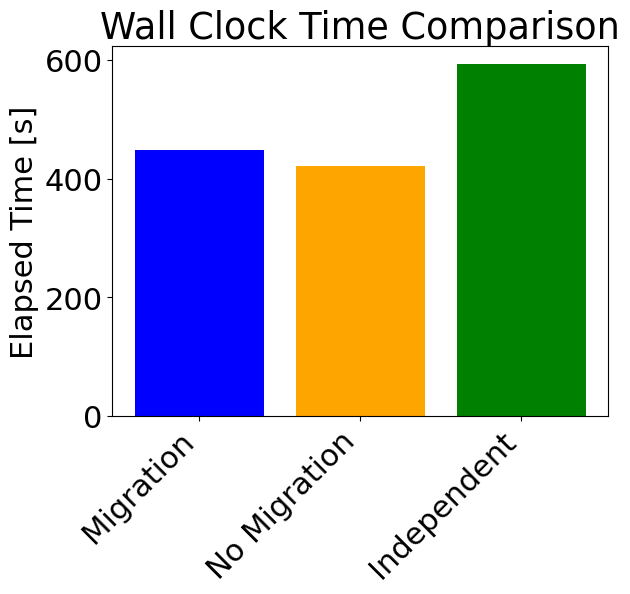

In [32]:
import re

def parse_elapsed_time(filename):
    with open(filename, 'r') as f:
        for line in f:
            if 'Elapsed (wall clock) time (h:mm:ss or m:ss)' in line:
                time_str = line.split(':', 4)[4].strip()
                #  "10:00.26" oppure "0:05:23" (h:mm:ss or m:ss)
                
                parts = time_str.split(':')
                # print(parts)
                if len(parts) == 3:  # h:mm:ss
                    h = int(parts[0])
                    m = int(parts[1])
                    s = float(parts[2])
                elif len(parts) == 2:  # mm:ss.ss
                    h = 0
                    m = int(parts[0])
                    s = float(parts[1])
                else:
                    raise ValueError("Unexpected time format")
                
                total_seconds = h*3600 + m*60 + s
                return total_seconds
    raise ValueError("Elapsed time not found")

elapsed_MIGRATION = parse_elapsed_time('MIGRATION/SOURCE/time.txt')
elapsed_NO_MIGRATION = parse_elapsed_time('NO_MIGRATION/SOURCE/time.txt')
elapsed_INDEPENDENT_GA = parse_elapsed_time('INDEPENDENT_GA/SOURCE/time.txt')


times = {
    "Migration": elapsed_MIGRATION,
    "No Migration": elapsed_NO_MIGRATION,
    "Independent": elapsed_INDEPENDENT_GA
}

names = list(times.keys())
values = list(times.values())

plt.bar(names, values, color=['blue', 'orange', 'green'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Elapsed Time [s]")
plt.title("Wall Clock Time Comparison")
plt.show()


| Setup        | Best Loss (L1, km) |
|--------------|--------------------|
| **Migration**   | **6223**            |
| No Migration | 6341               |
| Independent  | 6365               |


All three simulations successfully produced optimal or near-optimal solutions. In particular:

- **Visual inspection of the best paths found** confirmed that all routes were free from crossing lines, an indicator of optimal or near-optimal TSP solutions.
- **Convergence analysis** via the plots of the best loss and the average loss on the best half of the population showed decreasing trends, with the curves flattening as generations progressed, indicating convergence of the algorithm.
- For both **Migration** and **No Migration**, I plotted the loss evolution over generations **of the process that achieved the best final result**. This allows for a direct comparison of convergence behavior in the two parallel strategies.
- **Independent** search initially showed **faster convergence**, reaching lower loss values quickly during the first ~400 generations. However, after that point, **Migration overtakes**, benefiting from the periodic exchanges of good solutions between populations, ultimately achieving the lowest final loss.

**Comparison**: The Migration setup consistently produced slightly better solutions, suggesting that periodic exchange of the best individuals promotes exploration and helps prevent premature convergence. However, the difference in final loss values between the setups is relatively small, meaning that even independent searches or single-process GAs are effective for this problem.


**Timing considerations**: The Migration and No Migration parallel runs take approximately the same wall clock time, as they both utilize four processes concurrently. In contrast, the Independent single-process simulation requires about 150 seconds more to complete. This difference in computational time should be taken into account when comparing the effectiveness and efficiency of the different approaches.

Taking into account both solution quality and computational time, the use of MPI parallelization is essential—particularly to significantly speed up the execution of the algorithm. While Migration specifically provides a slight improvement in solution quality by promoting genetic diversity across populations, the major advantage of MPI lies in the reduction of execution time, making it a crucial tool for efficiently solving computationally intensive optimization problems like the TSP.

Overall, Migration offers a modest but noticeable improvement in solution quality, while MPI ensures a substantial gain in performance, particularly in terms of runtime.

